### ***Setup***

In [1]:
data_PATH = "./assets/original/CSV_Files/AODBData_2017_2022.csv"
weather_JSON_PATH = "./assets/original/JSON_Files/weather.json"
airports_JSON_PATH = "./assets/original/JSON_Files/airports.json"
result_PATH = "./assets/generated/result.csv"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

In [3]:
from data_preprocessing.Cleaner import Cleaner
from data_preprocessing.WeatherCollector import WeatherCollector
from data_preprocessing.FeatureExtractor import FeatureExtractor
from data_preprocessing.ArrivalDataSetCreator import ArrivalDataSetCreator

In [4]:
DATASET = pd.read_csv(data_PATH, index_col=False, parse_dates=['ETOA', 'ETOD'])
DATASET

C:\Users\Admin\AppData\Local\Temp\ipykernel_12584\4156636361.py:1: DtypeWarning: Columns (7,9,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  DATASET = pd.read_csv(data_PATH, index_col=False, parse_dates=['ETOA', 'ETOD'])


,Arr_FlightNo,Arr_Callsign,AC_Registration,AC_Type,Origin,Arr_ParkingStand,Flight_Type,Baggage_Belt,STOA,TMOA,...,On_Block,Dep_FlightNo,Dep_Callsign,Destination,Dep_ParkingStand,STOD,Gate,ETOD,Off_Block,Actual_Takeoff
0,SG 059,SEJ059,TCTJT,B738,VOML,C55L,PS,4,2.016123e+13,20161231223400,...,20161231224627,SG 058,SEJ058,VIJP,C55L,2.016123e+13,D12,20161231234000,2.016123e+13,2.017010e+13
1,EK 603,UAE603,A6ENC,B77W,OPKC,B23,PS,301,2.016123e+13,20161231212800,...,20161231213808,EK 041,UAE041,EGBB,B23,2.016123e+13,B24,20161231234500,2.016123e+13,2.017010e+13
2,EK 202,UAE202,A6EDM,A388,KJFK,F18,PS,304,2.016123e+13,20161231161837,...,20161231162700,EK 306,UAE306,ZBAA,F18,2.016123e+13,B13,20161231235000,2.016123e+13,2.017010e+13
3,EK 094,UAE094,A6EPB,B77W,LIPE,B24,PS,304,2.016123e+13,20161231221000,...,20161231221900,EK 388,UAE388,VVNB,B24,2.016123e+13,B26,20170101000000,2.016123e+13,2.017010e+13
4,EK 752,UAE752,A6EPI,B77W,GMMN,D03,PS,306,2.016123e+13,20161231213000,...,20161231213731,EK 101,UAE101,LIMC,D03,2.016123e+13,A10,20170101000000,2.016123e+13,2.017010e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974248,EK 020,UAE1C,A6EVA,A388,EGCC,A07,PS,305.0,2.022123e+13,20221231040245,...,20221231041123,EK 011,UAE9KC,EGKK,A07,2.022123e+13,A23,20221231233500,2.022123e+13,2.022123e+13
974249,EK 074,UAE65W,A6EVL,A388,LFPG,F08,PS,310.0,2.022123e+13,20221231194142,...,20221231195130,EK 362,UAE362,ZGGG,F08,2.022123e+13,C13,20221231232500,2.022123e+13,2.022123e+13
974250,EK 050,UAE8VC,A6EON,A388,EDDM,D08,PS,301.0,2.022123e+13,20221231194258,...,20221231195335,EK 231,UAE3MX,KIAD,D08,2.022123e+13,A15,20221231233500,2.022123e+13,2.022123e+13
974251,EK 040,UAE61H,A6ENA,B77W,EGBB,B14,PS,306.0,2.022123e+13,20221231201657,...,20221231202717,EK 368,UAE368,WADD,B14,2.022123e+13,B6,20221231233500,2.022123e+13,2.022123e+13


### ***Data Cleaning***

In [5]:
columns_to_drop = ['ID.1', 'ID.2']

illogical_order_cols = [
    ['%Y%m%d%H%M%S', ['Off_Block', 'Actual_Takeoff']],
    ['%Y%m%d%H%M%S', ['Landing_Time', 'On_Block']]
]

columns_to_check = ['Origin', 'Destination']
values_to_drop = ['LOCL', 'ZZZF']

In [6]:
cleaner = Cleaner(columns_to_drop=columns_to_drop, illogical_order_cols=illogical_order_cols, columns_to_check=columns_to_check, values_to_drop=values_to_drop)

### ***Weather Collecting***

In [7]:
new_column_names = ['Time', 'Temperature', 'Dew Point', 'Humidity', 'Wind',
 'Wind Speed', 'Wind Gust', 'Pressure', 'Precip.', 'Condition']
datetime_column = 'ETOA'
initial_columns = list(DATASET.columns)

In [8]:
weather_collector = WeatherCollector(
    weather_JSON_PATH=weather_JSON_PATH, datetime_column=datetime_column, \
    initial_columns=initial_columns, \
    new_column_names=new_column_names)

### ***Feature Engineering***

In [9]:
airport_json_data_path = airports_JSON_PATH
DXB_lat = 25.2527999878; DXB_lon = 55.3643989563
origin_df_col_name = 'Origin'; dest_df_col_name = 'Destination'
new_distance_cols_names = ['Origin_Dubai_Distance', 'Dubai_Dest_Distance']
col_name_to_extract_airline_from = 'Arr_FlightNo'; extracted_airline_col_name = 'Airline'

In [10]:
feature_extractor = FeatureExtractor(airport_json_data_path=airport_json_data_path, airport_lat=DXB_lat, airport_lon=DXB_lon,
                                         origin_df_col_name=origin_df_col_name, dest_df_col_name=dest_df_col_name, \
                                         new_distance_cols_names=new_distance_cols_names, \
                                         col_name_to_extract_airline_from=col_name_to_extract_airline_from, \
                                         extracted_airline_col_name=extracted_airline_col_name )

In [11]:
dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "month",
        "hour",
        "weekend",
    ],
)
cyclicf = CyclicalFeatures(
    variables=["month", "hour"],
    drop_original=False,
)
lagf = LagFeatures(
    variables=["Delay"],
    freq=["1H", "2H"], 
    missing_values="ignore",
)
winf = WindowFeatures(
    variables=["Delay"],
    window="24H",
    freq="1H",
    missing_values="ignore",
)

imputer = DropMissingData()

### ***Pipeline***

In [12]:
pipeline = Pipeline([
    ("Cleaning Data", cleaner),
    ("Collecting Weather", weather_collector),
    ("Arrival DataSet Creator", ArrivalDataSetCreator()),
    ("Feature Engineering", feature_extractor),
    ("datetime_features", dtf),
    ("lagf", lagf),
    ("winf", winf),
    ("Periodic", cyclicf),
    ("dropna", imputer),
])

In [14]:
DATASET_transformed = pipeline.fit_transform(DATASET)
DATASET_transformed.to_csv(result_PATH)
DATASET_transformed

Cleaning Data...
Dropped: 89557 rows.



Extracting new features...


,AC_Type,Origin,Flight_Type,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Delay,Origin_Dubai_Distance,...,month,hour,weekend,Delay_lag_1H,Delay_lag_2H,Delay_window_24H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 02:00:00,B77W,EDDF,PS,68.000000,63.000000,83.000000,3.000000,29.980000,43.764706,4844.856914,...,1,2,1,-5.714286,67.142857,30.714286,5.000000e-01,0.866025,0.519584,0.854419
2017-01-01 03:00:00,B77W,EGLL,PS,68.647059,62.941176,81.529412,5.176471,29.978824,76.411765,5497.925617,...,1,3,1,43.764706,-5.714286,35.064426,5.000000e-01,0.866025,0.730836,0.682553
2017-01-01 04:00:00,B77W,OTHH,PS,66.400000,61.400000,83.000000,3.400000,29.980000,57.200000,377.172129,...,1,4,1,76.411765,43.764706,45.401261,5.000000e-01,0.866025,0.887885,0.460065
2017-01-01 05:00:00,A388,EGLL,PS,66.000000,61.000000,83.000000,3.000000,29.980000,49.166667,5497.925617,...,1,5,1,57.200000,76.411765,47.761008,5.000000e-01,0.866025,0.979084,0.203456
2017-01-01 06:00:00,B738,VABB,PS,64.428571,61.000000,86.928571,4.571429,29.980000,44.285714,1926.162212,...,1,6,1,49.166667,57.200000,47.995285,5.000000e-01,0.866025,0.997669,-0.068242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,B77W,EDDF,PS,73.111111,57.000000,56.777778,10.111111,30.158333,34.666667,4844.856914,...,12,18,1,11.571429,5.500000,19.311847,-2.449294e-16,1.000000,-0.979084,0.203456
2022-12-31 19:00:00,A388,EDDM,PS,73.000000,57.000000,57.000000,8.000000,30.190000,3.777778,4564.010124,...,12,19,1,34.666667,11.571429,20.362541,-2.449294e-16,1.000000,-0.887885,0.460065
2022-12-31 20:00:00,B77W,EDDL,PS,73.000000,59.000000,61.000000,6.000000,30.190000,12.583333,5005.077573,...,12,20,1,3.777778,34.666667,19.980094,-2.449294e-16,1.000000,-0.730836,0.682553


In [ ]:
data_encoded = DATASET_transformed.copy()
categorical_cols = data_encoded.select_dtypes(include=['object']).columns
print(categorical_cols)
label_encoder = LabelEncoder()
onehot_counter = 0
label_counter = 0
for col in categorical_cols:
    if data_encoded[col].nunique() == 2:
        data_encoded[col] = label_encoder.fit_transform(data_encoded[col])
        print('Label encoded: ', col)
        label_counter += 1
    else:
        data_encoded = pd.get_dummies(data_encoded, columns=[col])
        print('One-hot encoded: ', col)
        onehot_counter += 1
data_encoded = data_encoded.replace({True: 1, False: 0})
data_encoded

In [30]:
# input data
X_train = data_encoded[data_encoded.index < "2022-01-01"]
X_test = data_encoded[data_encoded.index >= pd.Timestamp("2022-01-01")]

# target
y_train = data_encoded[data_encoded.index < "2022-01-01"]["Delay"]
y_test = data_encoded[data_encoded.index >= pd.Timestamp("2022-01-01")]["Delay"]

X_train = X_train.drop("Delay", axis=1)
X_test = X_test.drop("Delay", axis=1)

In [31]:
categorical_cols

Index(['AC_Type', 'Origin', 'Flight_Type'], dtype='object')

In [34]:
columns_to_scale = list(DATASET_transformed.columns.difference(data_encoded.columns.difference(data_encoded.columns)))
columns_to_scale = [item for item in columns_to_scale if item not in categorical_cols]
columns_to_scale.remove("Delay")
columns_to_scale

['Temperature',
 'Dew Point',
 'Humidity',
 'Wind Speed',
 'Pressure',
 'Origin_Dubai_Distance',
 'holidays',
 'month',
 'hour',
 'weekend',
 'Delay_lag_1H',
 'Delay_lag_2H',
 'Delay_window_24H_mean',
 'month_sin',
 'month_cos',
 'hour_sin',
 'hour_cos']

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler.transform(X_test[columns_to_scale])

X_train.drop(columns_to_scale, axis=1, inplace=True)
X_train[columns_to_scale] = X_train_scaled

X_test.drop(columns_to_scale, axis=1, inplace=True)
X_test[columns_to_scale] = X_test_scaled

X_train

,AC_Type_A20N,AC_Type_A21N,AC_Type_A306,AC_Type_A310,AC_Type_A319,AC_Type_A320,AC_Type_A321,AC_Type_A332,AC_Type_A333,AC_Type_A338,...,month,hour,weekend,Delay_lag_1H,Delay_lag_2H,Delay_window_24H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,-1.589205,-1.372614,1.583253,-0.482695,3.365309,2.880737,0.743015,1.166214,0.757070,1.121548
2017-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,-1.589205,-1.228543,1.583253,2.132600,-0.483441,3.340116,0.743015,1.166214,1.062512,0.883101
2017-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,-1.589205,-1.084472,1.583253,3.858215,2.130335,4.431696,0.743015,1.166214,1.289584,0.574422
2017-01-01 05:00:00,0,0,0,0,0,0,0,0,0,0,...,-1.589205,-0.940400,1.583253,2.842745,3.854948,4.680888,0.743015,1.166214,1.421445,0.218403
2017-01-01 06:00:00,0,0,0,0,0,0,0,0,0,0,...,-1.589205,-0.796329,1.583253,2.418129,2.840068,4.705628,0.743015,1.166214,1.448316,-0.158551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0,0,0,0,0,0,0,0,0,0,...,1.525223,1.076600,-0.631611,0.834191,1.123978,2.540275,0.039185,1.357164,-1.277938,0.574422
2021-12-31 20:00:00,0,0,0,0,0,0,0,0,0,0,...,1.525223,1.220671,-0.631611,0.313349,0.832680,2.509658,0.039185,1.357164,-1.050866,0.883101
2021-12-31 21:00:00,0,0,0,0,0,0,0,0,0,0,...,1.525223,1.364743,-0.631611,0.255410,0.312141,2.440558,0.039185,1.357164,-0.745425,1.121548


## ***Models***

### ***Random Forest Model***

In [39]:
rf_model = RandomForestRegressor(
    n_estimators=5,
    max_depth=1,
    random_state=0,
)

rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
print("train rmse: ", mean_squared_error(y_train, y_train_pred, squared=False,))

y_test_pred = rf_model.predict(X_test)
print("test rmse: ",  mean_squared_error(y_test, y_test_pred, squared=False,))

train rmse:  18.1907554038618
test rmse:  15.711782355813545


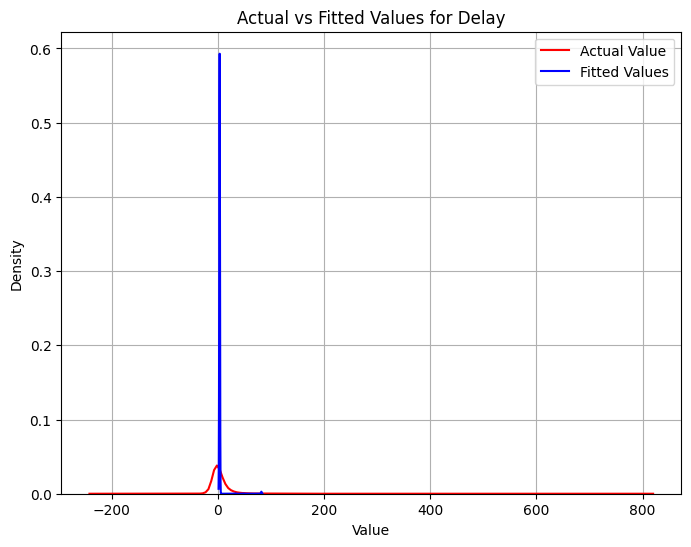

In [40]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_train, color="r", label="Actual Value")
sns.kdeplot(y_train_pred, color="b", label="Fitted Values")
plt.title('Actual vs Fitted Values for Delay')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Importance')

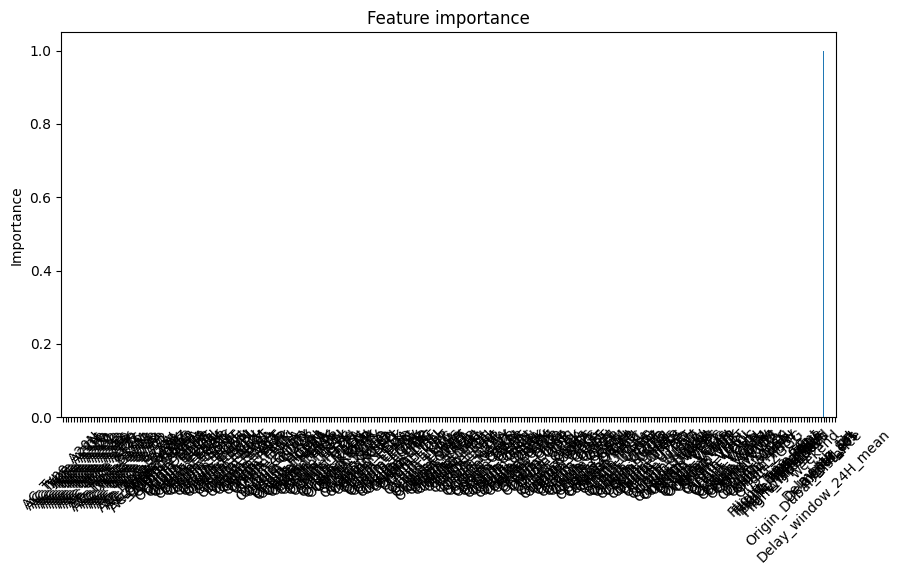

In [41]:
# Create series with feature importance.
tmp = pd.Series(rf_model.feature_importances_)
tmp.index = X_train.columns
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")

### ***Linear Regression Model***

In [42]:
linear_model = Lasso(alpha=100, random_state=0)
linear_model.fit(X_train, y_train)

lasso_y_train_pred = linear_model.predict(X_train)
print("train rmse: ", mean_squared_error(y_train, lasso_y_train_pred, squared=False,))

lasso_y_test_pred = linear_model.predict(X_test)
print("test rmse: ",  mean_squared_error(y_test, lasso_y_test_pred, squared=False,))

train rmse:  19.025729921105665
test rmse:  15.90160241065829


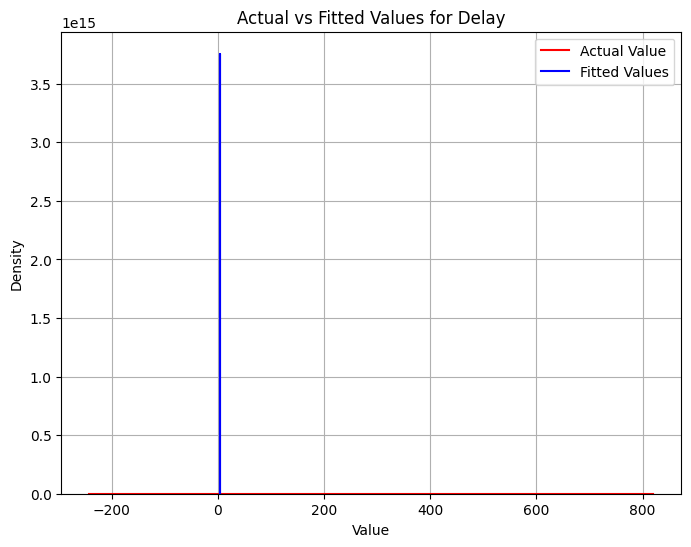

In [45]:
plt.figure(figsize=(8, 6))
sns.kdeplot(y_train, color="r", label="Actual Value")
sns.kdeplot(lasso_y_train_pred, color="b", label="Fitted Values")
plt.title('Actual vs Fitted Values for Delay')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Importance')

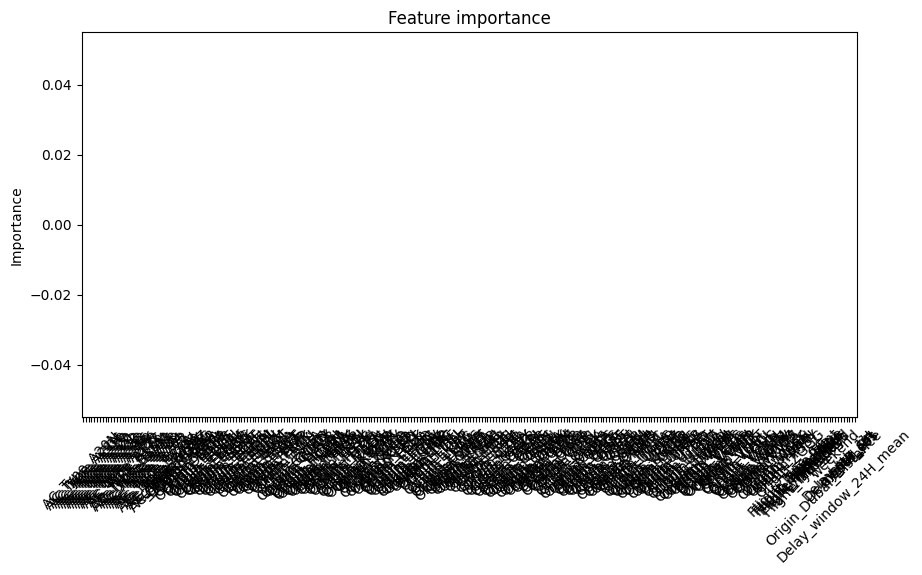

In [44]:
from numpy import abs
# Create series with feature importance.
tmp = pd.Series(abs(linear_model.coef_))
tmp.index = X_train.columns
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")